# Recommendation Systems


There are two approaches for recommending items
<br>
    1.Collaborative<br> 
    2.Content based
    
Colloaborative filtering does not need any explicit item or user features for new recommendations.It relies fully on the user-item interactions which hold the user's preference for an item which could be described by ratings,stars etc.

Whereas Content based approach relies on other explicit features of users and items such as age,gender,country,director of a film,year of release etc.This better estimates how an user would to a given item, thus giving a better recommendation.

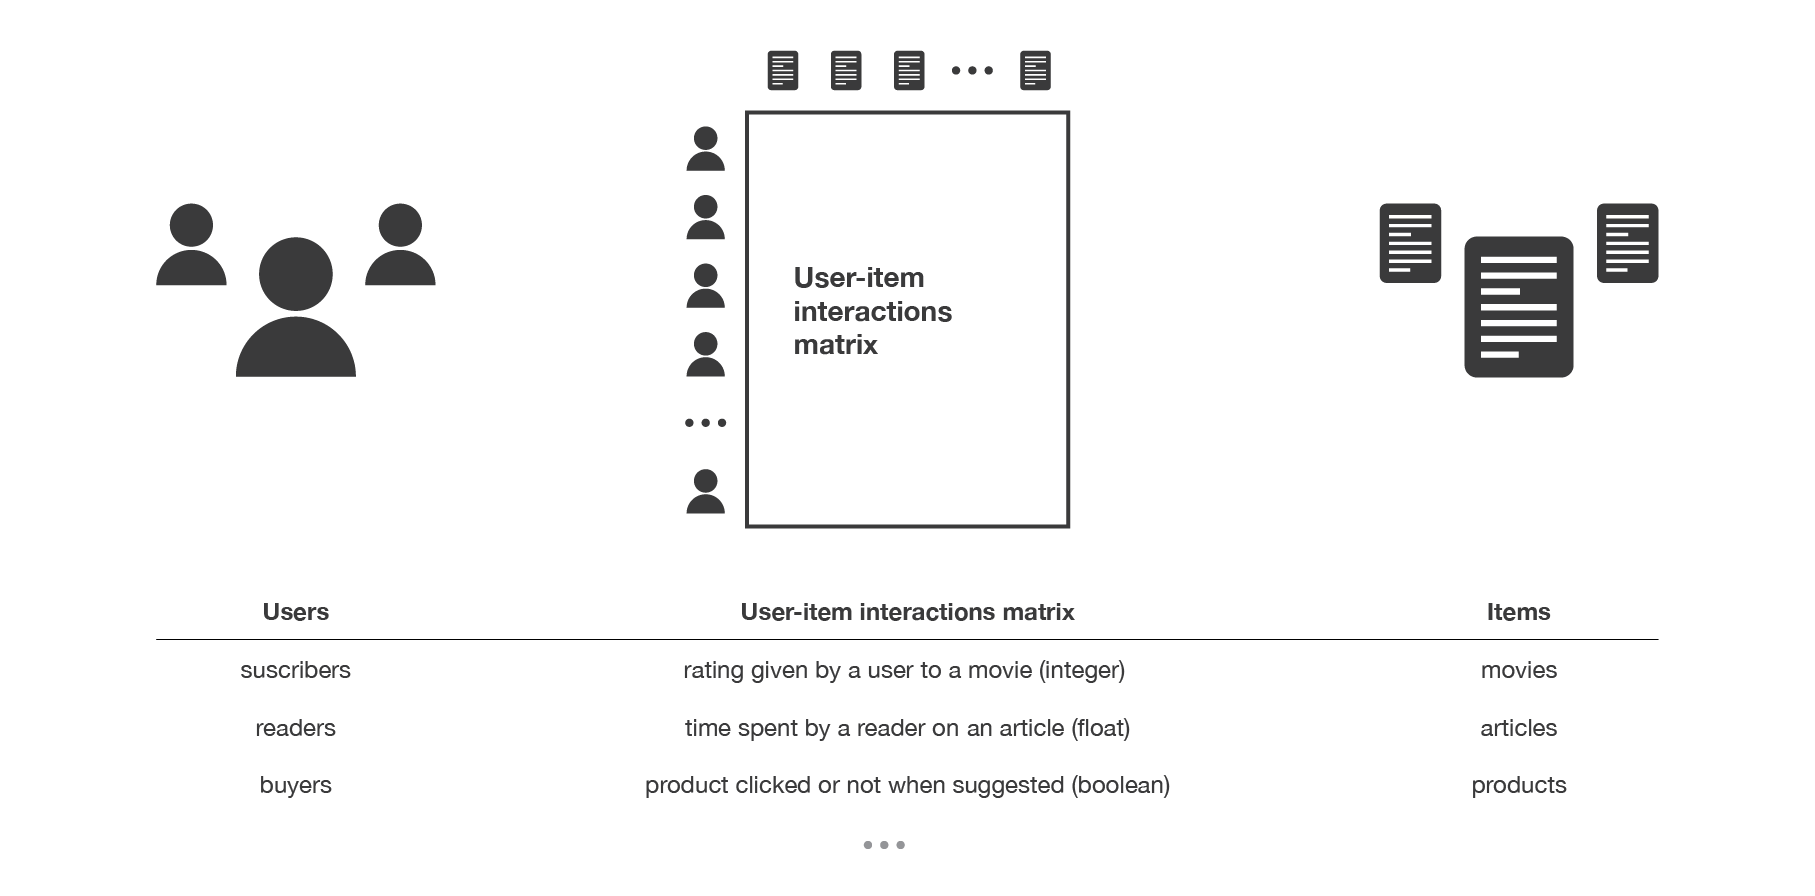

The above diagram displays the user-item interaction matrix containing ratings etc. This would be the main input we would use to recommend.

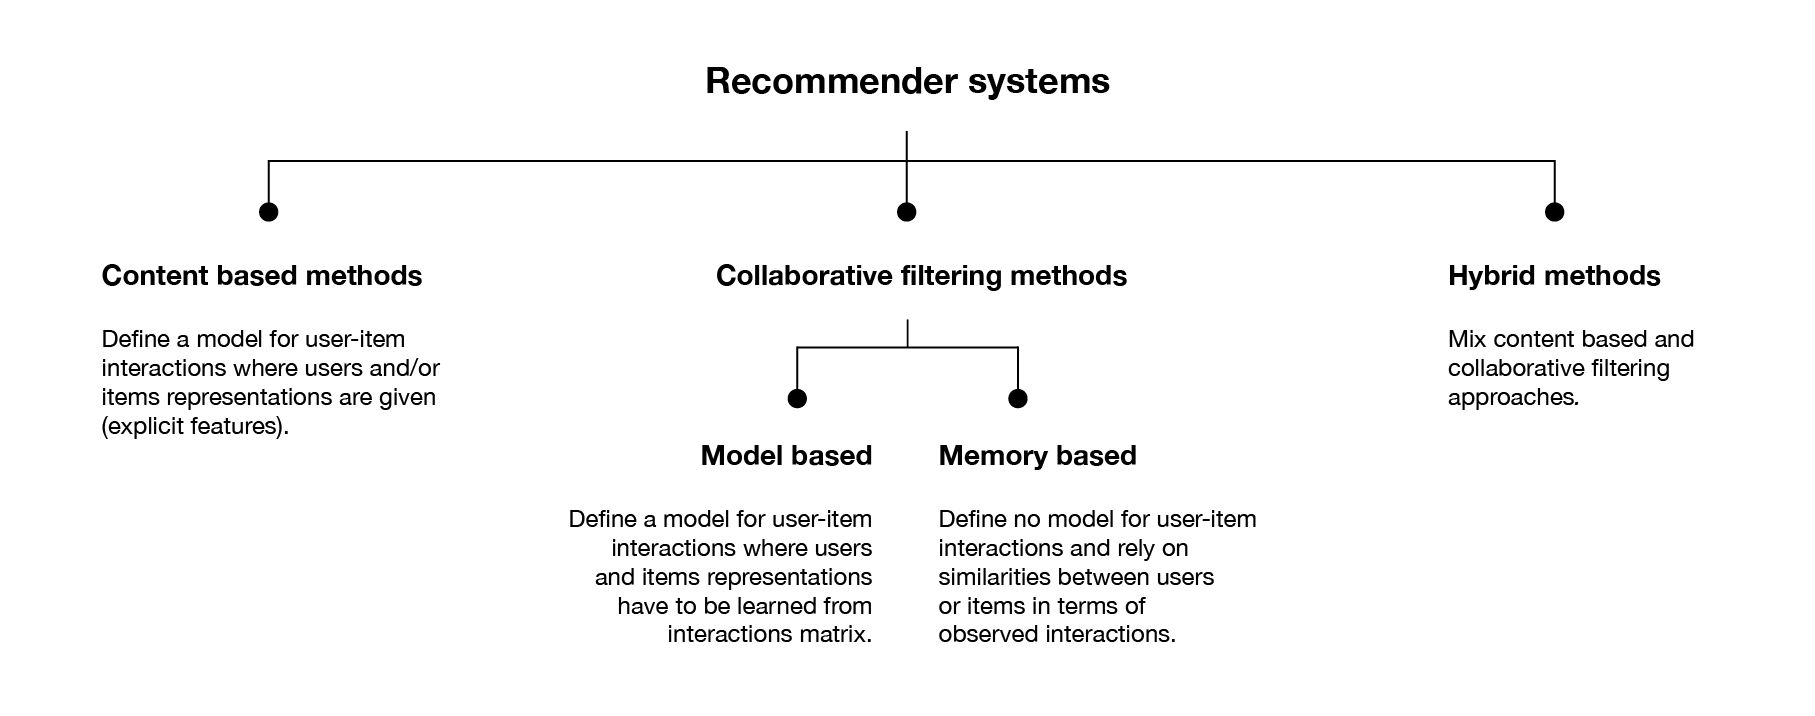

Here we would mainly focus on hybrid matrix factorisation which would be a mix of content and collaborative approaches.Before that lets see how basic matrix factorisation works.

Being a model-based approach, matrix factoriation assumes that there is latent model which explains all ratings/data present in the user-item interaction matrix.The fundamental principle is to decompose huge and a sparse rating matrix into two smaller and dense matrices.         

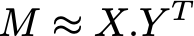

Where X represents the user factor matrix and Y represents the item factor matrix
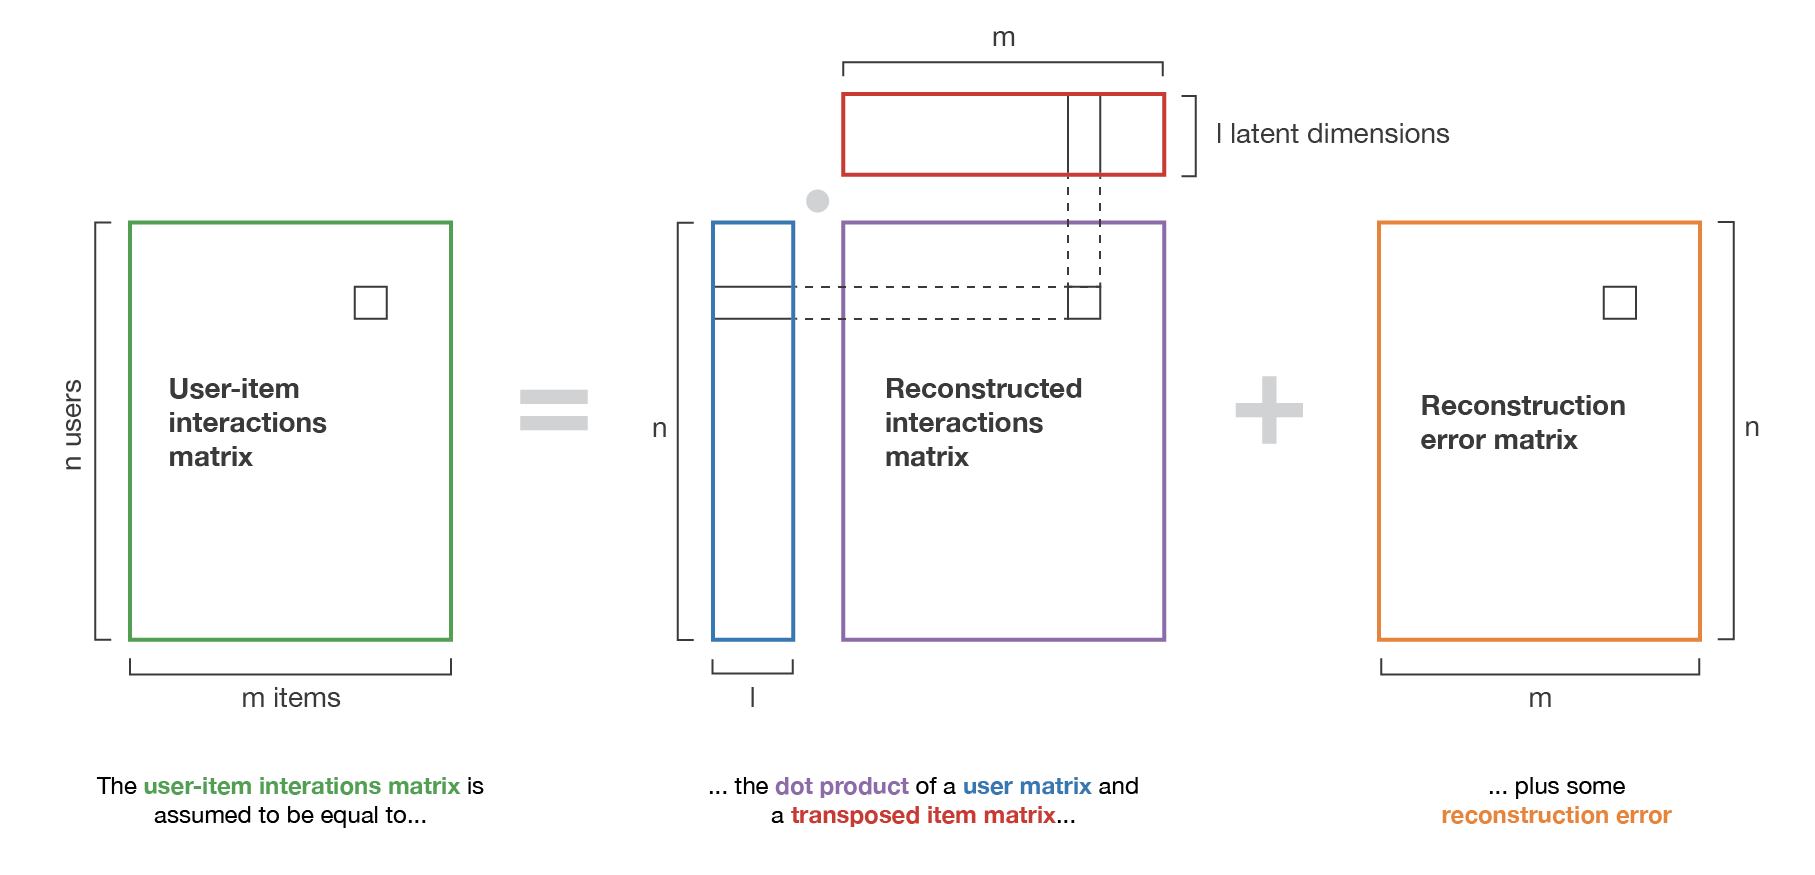
Thus our goal would be to find X and Y such that
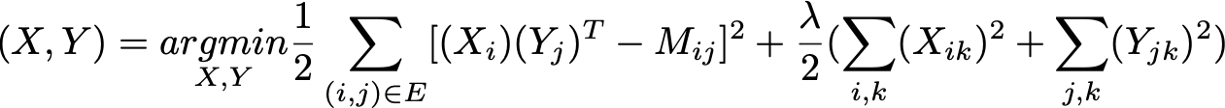
Where lamda is regularisation factor.
Once the interaction matrix is factorised,we just simply have to take an user vector from X and multiply it to all the item vectors that the user hasnt seen to get the model predicted ratings.

Now that we have seen basic matrix factorisation,lets turn our focus to hybrid matrix factorisation,which is more or less the same idea.
# Hybrid matrix Factorisation
The idea behind HMF is that we simply try to incorporate all the user and item features in the decomposed matrices.So here we would factorise our rating matrix into    where U and V are item and user factor matrices respectively. The exlicit factors are included in U and V like,
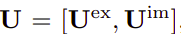 and 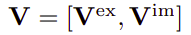. What we will do is consider item features separately and user features separately. When taking item features into account,we will have weights for these features in the user matrix,similarly when we consider user features.
At the end we would take average of the ratings predicted by the both sides of features.
Our objective function would be:
<br>
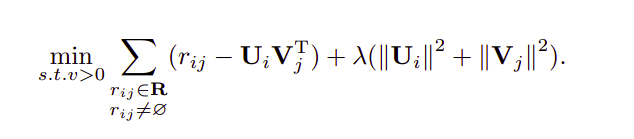
<br>
Apart from the L2 norm,L1 norm also is added to facilitate feature selection.

## Solution of HMF
There are multiple ways of convergence for HMF.
<br>
1.Stochastic Gradient Descent
<br>
2.Alternating Least Squares
<br>
3.Coordinate Descent
<br>
Out of these SGD seems to outperform all.Here we have implemented only SGD and ALS.
<br>
For SGD the update rules will be:
<br>
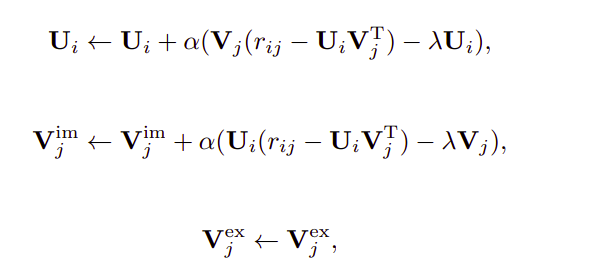
<br>
As you can see, we dont want to update the explicit factors.They would remain the same for all iterations.The same update rule will once again be done on user-only features.
<br>
Since we'll mainly focus on SGD, I have added the update rules and algorithms for ALS and CD at last.
## Interpretation and Cold Start
In basic MF,interpretation of the data is impossible as we wont know what features affect ratings the most.Whereas since we use explicit attributes in HMF,interpretation is possbile.The weights of explicit attributes represent the preference of items by the user.
<br>
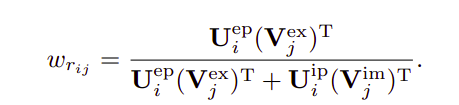
<br>
Similarly it is impossible to recommend new users or new items in basic MF,whereas in HMF, we can find ideal users to recommend new items based on their weights for item explicit features.Same would fit for new users.
<br>
<br>
<br>
Let's code!
# Dataset
I have used the movielens 100k dataset.It can be downloaded from https://www.kaggle.com/prajitdatta/movielens-100k-dataset

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import os
from sklearn import preprocessing as pp
from numpy.linalg import norm
from sklearn.model_selection import KFold
from surprise import NMF,SVD
from surprise import Dataset
from surprise.model_selection import cross_validate
import time

In [10]:
os.chdir('/media/kamalesh/KAMALESH/ds/ml-100k')


# Preprocessing

In [11]:

df=pd.read_csv('u.data',delim_whitespace=True,header=None)
df.columns=['userid','movieid','rating','timestamp']
df.head(20)

,userid,movieid,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596
5,298,474,4,884182806
6,115,265,2,881171488
7,253,465,5,891628467
8,305,451,3,886324817
9,6,86,3,883603013


In [12]:
user_df=pd.read_csv('u.user',delimiter='|',header=None)
user_df.columns=['userid','age','gender','occupation','zipcode']

In [13]:
mlb=pp.MultiLabelBinarizer()# Here we create encode all the explicit attributes
gender=mlb.fit_transform(user_df['gender'])
zipcode=mlb.fit_transform(user_df['zipcode'])
occupation=mlb.fit_transform(user_df['occupation'])

In [14]:
scale=pp.MinMaxScaler() #feature scaling age
age_scaled=scale.fit_transform(user_df['age'].to_numpy().reshape(-1,1))
user_explicit=np.concatenate((age_scaled,gender,zipcode),axis=1)

In [15]:
movie_df=pd.read_csv('u.item',delimiter='|',header=None)
movie_explicit=movie_df.to_numpy()[:,5:]
item_name=movie_df.to_numpy()[:,1]

The user explicit attributes that we would use are age,gender and zipcode(country or state would have been better)Item explicit features would be genre

In [16]:
n_epoch=100 # no.of iterations
alpha=0.025 # learning rate
alpha_decay=0.97 
lamda=0.1 # regularisation parameter.
n_folds=5 # for implementing k-fold
latent=5 # extra latent features apart from all explicit attributes
l1_ratio=0.006 # ideally would 0 if you dont want harsh feature selection

class HMF:
    
    def __init__(self,user_explicit,item_explicit):      
        
        self.user_explicit=user_explicit #explicit features of users
        self.item_explicit=item_explicit #explicit features of items
        
    def loss_userfree(self):  
        '''
        loss calculated with user_free and item_matrix
        '''

        return 0.5*(norm(np.nan_to_num((self.rating_matrix-np.dot(self.user_free,self.item_matrix.T)).astype(np.float64)))**2+lamda*(1-l1_ratio)*(norm(self.user_free)**2 + norm(self.item_matrix)**2))+lamda*l1_ratio*(np.sum(np.absolute(self.user_free))+np.sum(np.absolute(self.item_matrix)))

    def loss_itemfree(self): 
        '''
        loss calculated with item_free and user_matrix
        '''
        
        return 0.5*(norm(np.nan_to_num((self.rating_matrix-np.dot(self.user_matrix,self.item_free.T)).astype(np.float64)))**2+lamda*(1-l1_ratio)*(norm(self.item_free)**2 + norm(self.user_matrix)**2))+lamda*l1_ratio*(np.sum(np.absolute(self.user_matrix))+np.sum(np.absolute(self.item_free)))
    
    def total_cost(self):
        '''
        Normalised average of the above two losses
        '''
        
        return (self.loss_userfree()+self.loss_itemfree())/(2*self.len_train)
    
    def eval_metric(self): # Evaluates metrc
        
        self.mean_prediction=0.5*(np.dot(self.user_free,self.item_matrix.T)+np.dot(self.user_matrix,self.item_free.T))
        #mean prediciton from user features and item features separately after every epoch
        np.place(self.mean_prediction,self.mean_prediction>5,5) #predicitons above 5 replaced with 5
        np.place(self.mean_prediction,self.mean_prediction<1,1) #predicitons below 1 replaced with 1
        error_train=np.nan_to_num((self.rating_matrix-self.mean_prediction).astype(np.float64))
        MAE_train=np.sum(np.absolute(error_train))/self.len_train
        RMSE_train=np.sqrt(np.sum(error_train**2)/self.len_train)  
        error_test=np.nan_to_num((self.test_set-self.mean_prediction).astype(np.float64))
        MAE_test=np.sum(np.absolute(error_test))/self.len_test
        RMSE_test=np.sqrt(np.sum(error_test**2)/self.len_test)
        self.cost_history.append(RMSE_train)
        self.test_history.append(RMSE_test)
        if((self.epoch+1)%5==0 or self.epoch==0):
            print('Epoch',self.epoch+1,'RMSE TRAIN:',RMSE_train,'MAE TEST:',MAE_test,'RMSE TEST:',RMSE_test)  
    
    def initialise(self):
        ''' 
        Initialises all factor matrices randomly before every fold
        
        user_implicit: matrix for latent features of users
        item_implicit: matrix for latent features of items
        
        user_matrix: matrix with explicit and implicit features embedded for users
        item_matrix: matrix with explicit and implicit features embedded for item
        
        user_free:decomposed factor matrix along with item_matrix.Free denotes free of user features.
        item_free:decomposed factor matrix along with user_matrix.Free denotes free of item features.
        
        '''
        
        user_implicit=np.random.rand(self.user_count,latent)
        item_implicit=np.random.rand(self.item_count,latent)
        self.user_matrix=np.concatenate((self.user_explicit,user_implicit),axis=1)
        self.item_matrix=np.concatenate((self.item_explicit,item_implicit),axis=1) 
        self.user_free=np.random.rand(self.user_count,latent+self.item_explicit.shape[1])
        self.item_free=np.random.rand(self.item_count,latent+self.user_explicit.shape[1])
        self.cost_history=[]
        self.test_history=[]
        self.objective_history=[]
        self.alpha=alpha 
        
    def store(self): # stores the history
        
        self.mean_train.append(self.cost_history[self.epoch-1])
        self.mean_test.append(self.test_history[self.epoch-1])    
        self.prediction_sum=self.prediction_sum+self.mean_prediction
        self.user_free_sum=self.user_free_sum+self.user_free
        self.item_free_sum=self.item_free_sum+self.item_free
              
    def update_sgd(self,user_index,item_index): #SGD
        
        self.initialise()
        for self.epoch in range(n_epoch):          
            for i,j in zip(user_index,item_index):
                error1=self.rating_matrix[i,j]-np.dot(self.user_free[i,:],self.item_matrix[j,:].T)
                item_copy=self.item_matrix[j,:]
                self.item_matrix[j,:]=self.item_matrix[j,:]+self.alpha*(self.user_free[i,:]*error1-lamda*(1-l1_ratio)*self.item_matrix[j,:]-lamda*l1_ratio*np.sign(self.item_matrix[j,:]))
                self.user_free[i,:]=self.user_free[i,:]+self.alpha*(item_copy*error1-lamda*(1-l1_ratio)*self.user_free[i,:]-lamda*l1_ratio*np.sign(self.user_free[i,:])) 
                self.item_matrix[j,:self.item_explicit.shape[1]]=self.item_explicit[j,:]
                error2=self.rating_matrix[i,j]-np.dot(self.user_matrix[i,:],self.item_free[j,:].T)
                user_copy=self.user_matrix[i,:]
                self.user_matrix[i,:]=self.user_matrix[i,:]+self.alpha*(self.item_free[j,:]*error2-lamda*(1-l1_ratio)*self.user_matrix[i,:]-lamda*l1_ratio*np.sign(self.user_matrix[i,:]))
                self.item_free[j,:]=self.item_free[j,:]+self.alpha*(user_copy*error2-lamda*(1-l1_ratio)*self.item_free[j,:]-lamda*l1_ratio*np.sign(self.item_free[j,:]))
                self.user_matrix[i,:self.user_explicit.shape[1]]=self.user_explicit[i,:]   
            self.alpha=self.alpha*alpha_decay
            self.eval_metric()
            self.objective_history.append(self.total_cost())
        self.store()
        
    def update_als(self,user_index,item_index): # ALS
        
        self.initialise()
        for self.epoch in range(n_epoch):
            for i in range(self.user_count):
                sum_usermatrix=np.zeros_like(self.user_matrix[0,:])
                sum_userfree=np.zeros_like(self.user_free[0,:])
                for j in range(self.item_count):
                    if(~np.isnan(self.rating_matrix[i,j])):
                        sum_usermatrix=sum_usermatrix+(self.rating_matrix[i,j]*self.item_free[j,:])/(np.sum(self.item_free[j,:]**2)+lamda)
                        sum_userfree=sum_userfree+(self.rating_matrix[i,j]*self.item_matrix[j,:])/(np.sum(self.item_matrix[j,:]**2)+lamda)
        
                self.user_free[i,:]=sum_userfree
                self.user_matrix[i,:]=sum_usermatrix
                self.user_matrix[i,:self.user_explicit.shape[1]]=self.user_explicit[i,:]  
            for j in range(self.item_count):
                sum_itemmatrix=np.zeros_like(self.item_matrix[0,:])
                sum_itemfree=np.zeros_like(self.item_free[0,:])
                for i in range(self.user_count):
                    if(~np.isnan(self.rating_matrix[i,j])):
                        sum_itemmatrix=sum_itemmatrix+(self.rating_matrix[i,j]*self.user_free[i,:])/(np.sum(self.user_free[i,:]**2)+lamda)
                        sum_itemfree=sum_itemfree+(self.rating_matrix[i,j]+self.user_matrix[i,:])/(np.sum(self.user_matrix[i,:]**2)+lamda)
                
                self.item_free[j,:]=sum_itemfree
                self.item_matrix[j,:]=sum_itemmatrix
                self.item_matrix[j,:self.item_explicit.shape[1]]=self.item_explicit[j,:]
            self.eval_metric()
            self.objective_history.append(self.total_cost())
        self.store()

    def plot(self):  
        
        fig,(ax1,ax2)=plt.subplots(1,2)        
        ax1.set_xlabel('no.of epochs')
        ax1.set_ylabel('error')
        ax2.set_xlabel('no.of epochs')
        ax2.plot(np.arange(len(self.objective_history)),self.objective_history,'-g',label='objective')
        ax1.plot(np.arange(len(self.cost_history)),self.cost_history,'-b',label='training RMSE')
        ax1.plot(np.arange(len(self.test_history)),self.test_history,'-r',label='testing RMSE')
        ax1.legend()
        ax2.legend()
        plt.show()
            
    def recommend_items(self,top_n,user_id): 
        
        recommendations=[]
        for item_id in range(self.item_count):     
            if(np.isnan(self.inter_matrix[user_id-1,item_id])): 
                recommendations.append([self.final_prediciton[user_id-1,item_id],item_id])
        recommendations.sort(key=lambda x: x[0],reverse=True)
        print('Top',top_n,'picks are:')
        for i in range(top_n):
            print('item id:',recommendations[i][1]+1,'Name:',item_name[recommendations[i][1]])   

    def recommend_users(self,top_n,item_id):
        
        recommendations=[]
        for user_id in range(self.user_count):
            if(np.isnan(self.inter_matrix[user_id,item_id-1])):
                recommendations.append([self.final_prediciton[user_id,item_id-1],user_id])
        recommendations.sort(key=lambda x: x[0],reverse=True)
        print('Top',top_n,'users to recommend this item: ')
        for i in range(top_n):
            print('user id',recommendations[i][1]+1)

    def cross_validation(self,inter_data,method):
        
        init_time=time.time()
        self.user_count=len(np.unique(inter_data[:,0]))
        self.item_count=len(np.unique(inter_data[:,1]))
        userid=inter_data[:,0]
        itemid=inter_data[:,1]
        self.inter_matrix=np.empty((self.user_count,self.item_count))
        self.inter_matrix[:]=np.nan
        self.inter_matrix[userid-1,itemid-1]=inter_data[:,2]     
        self.mean_train=[]        
        self.mean_test=[]
        self.prediction_sum=np.zeros((self.user_count,self.item_count))
        self.user_free_sum=np.zeros((self.user_count,latent+self.item_explicit.shape[1]))
        self.item_free_sum=np.zeros((self.item_count,latent+self.user_explicit.shape[1]))
        kf=KFold(n_splits=n_folds)
        for train_index,test_index in kf.split(inter_data):
            self.test_set=np.empty((self.user_count,self.item_count))
            self.test_set[:]=np.nan
            self.test_set[inter_data[test_index,0]-1,inter_data[test_index,1]-1]=inter_data[test_index,2]
            self.len_train=len(train_index)
            self.len_test=len(test_index)
            userid=inter_data[train_index,0]
            itemid=inter_data[train_index,1]
            self.rating_matrix=np.empty((self.user_count,self.item_count))
            self.rating_matrix[:]=np.nan 
            self.rating_matrix[userid-1,itemid-1]=inter_data[train_index,2] 
            if(method=='sgd'):
                self.update_sgd(userid-1,itemid-1)
            elif(method=='als'):
                self.update_als(userid-1,itemid-1)
            elif(method=='cd'):
                self.update_cd(userid-1,itemid-1)           
            self.plot()
        self.final_prediciton=self.prediction_sum/n_folds
        self.final_user_free=self.user_free_sum/n_folds
        self.final_item_free=self.item_free_sum/n_folds
        print('time taken:',time.time()-init_time,'secs')
        print('MEAN RMSE TRAINING:',np.mean(self.mean_train),'MEAN RMSE TESTING:',np.mean(self.mean_test))  


Epoch 1 RMSE TRAIN: 0.9128587681592636 MAE TEST: 0.798640690754374 RMSE TEST: 0.998856854703477
Epoch 5 RMSE TRAIN: 0.8446727730112316 MAE TEST: 0.7736816143923272 RMSE TEST: 0.9713535642954385
Epoch 10 RMSE TRAIN: 0.8106101973309733 MAE TEST: 0.7626137129890864 RMSE TEST: 0.9584176984355862
Epoch 15 RMSE TRAIN: 0.7874986296550476 MAE TEST: 0.7537396301104939 RMSE TEST: 0.9480892063537443
Epoch 20 RMSE TRAIN: 0.7736038368674402 MAE TEST: 0.748629574150949 RMSE TEST: 0.9421006974340413
Epoch 25 RMSE TRAIN: 0.7647337981498555 MAE TEST: 0.7453193298757803 RMSE TEST: 0.9381710939988969
Epoch 30 RMSE TRAIN: 0.7587426497720473 MAE TEST: 0.7429944694816855 RMSE TEST: 0.9353911967329603
Epoch 35 RMSE TRAIN: 0.7545063150900561 MAE TEST: 0.7412938490348868 RMSE TEST: 0.9333325249973581
Epoch 40 RMSE TRAIN: 0.7514074538211509 MAE TEST: 0.7399749273613279 RMSE TEST: 0.9317590532341502
Epoch 45 RMSE TRAIN: 0.7490848385247724 MAE TEST: 0.7389409106377722 RMSE TEST: 0.9305361058224971
Epoch 50 RMSE T

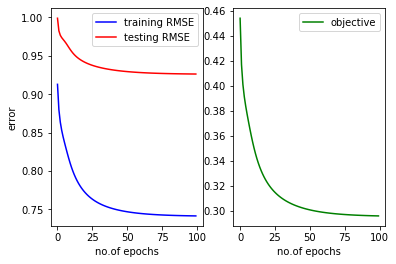

Epoch 1 RMSE TRAIN: 0.9128576403207134 MAE TEST: 0.7810969723441837 RMSE TEST: 0.985396827233444
Epoch 5 RMSE TRAIN: 0.8446915479092797 MAE TEST: 0.7615918031657667 RMSE TEST: 0.9613098276138493
Epoch 10 RMSE TRAIN: 0.8085606167370053 MAE TEST: 0.7505908264168667 RMSE TEST: 0.9484868471588844
Epoch 15 RMSE TRAIN: 0.7861534596496936 MAE TEST: 0.7432848399465892 RMSE TEST: 0.9399945637783585
Epoch 20 RMSE TRAIN: 0.7730098814792615 MAE TEST: 0.7395319050823393 RMSE TEST: 0.9353603659318965
Epoch 25 RMSE TRAIN: 0.764504691273213 MAE TEST: 0.737051626568428 RMSE TEST: 0.932204528450859
Epoch 30 RMSE TRAIN: 0.7586845374799756 MAE TEST: 0.735171929882762 RMSE TEST: 0.929823570388485
Epoch 35 RMSE TRAIN: 0.7545366905480944 MAE TEST: 0.7337072518123626 RMSE TEST: 0.9279541237391091
Epoch 40 RMSE TRAIN: 0.7514903065391124 MAE TEST: 0.7325347445128798 RMSE TEST: 0.9264644526326421
Epoch 45 RMSE TRAIN: 0.7492055451999757 MAE TEST: 0.7316209554413766 RMSE TEST: 0.9252713411226913
Epoch 50 RMSE TRAI

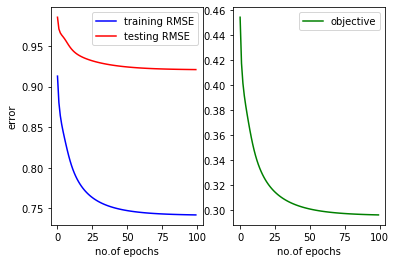

Epoch 1 RMSE TRAIN: 0.9142479378563165 MAE TEST: 0.780983885466343 RMSE TEST: 0.9769776533672417
Epoch 5 RMSE TRAIN: 0.84815069353999 MAE TEST: 0.7620953839010105 RMSE TEST: 0.9556120764522794
Epoch 10 RMSE TRAIN: 0.8121766521311651 MAE TEST: 0.7505303295249708 RMSE TEST: 0.9423479478383231
Epoch 15 RMSE TRAIN: 0.7878598460518704 MAE TEST: 0.741574500807396 RMSE TEST: 0.9323374229023766
Epoch 20 RMSE TRAIN: 0.7741617239541202 MAE TEST: 0.736827225299705 RMSE TEST: 0.9271010303101721
Epoch 25 RMSE TRAIN: 0.7654099018227977 MAE TEST: 0.733785026438963 RMSE TEST: 0.923692649851195
Epoch 30 RMSE TRAIN: 0.7594404998574505 MAE TEST: 0.731578666434336 RMSE TEST: 0.9212469723795034
Epoch 35 RMSE TRAIN: 0.755194107227194 MAE TEST: 0.7299154778813047 RMSE TEST: 0.9194127506554641
Epoch 40 RMSE TRAIN: 0.7520823709337036 MAE TEST: 0.7286377723438326 RMSE TEST: 0.9180071089148082
Epoch 45 RMSE TRAIN: 0.7497528206931375 MAE TEST: 0.7276541349208057 RMSE TEST: 0.9169163967183678
Epoch 50 RMSE TRAIN: 

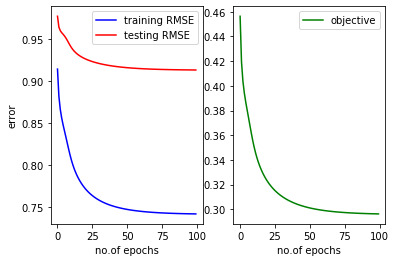

Epoch 1 RMSE TRAIN: 0.9158379184751695 MAE TEST: 0.7785309532242172 RMSE TEST: 0.9759150455099787
Epoch 5 RMSE TRAIN: 0.8459175941024685 MAE TEST: 0.7610784023457002 RMSE TEST: 0.956201720542004
Epoch 10 RMSE TRAIN: 0.808313535870903 MAE TEST: 0.750611680700972 RMSE TEST: 0.9446226417086451
Epoch 15 RMSE TRAIN: 0.786224804306603 MAE TEST: 0.7440623062014752 RMSE TEST: 0.937437834149227
Epoch 20 RMSE TRAIN: 0.7734988698977164 MAE TEST: 0.7406185936035184 RMSE TEST: 0.9337357557429932
Epoch 25 RMSE TRAIN: 0.7651565301364089 MAE TEST: 0.7383621227536703 RMSE TEST: 0.9312269668902162
Epoch 30 RMSE TRAIN: 0.7593479254060751 MAE TEST: 0.7366285464569634 RMSE TEST: 0.9292912035165467
Epoch 35 RMSE TRAIN: 0.7551415644703141 MAE TEST: 0.7352637576741181 RMSE TEST: 0.9277240969421999
Epoch 40 RMSE TRAIN: 0.7520110950491484 MAE TEST: 0.7341349124290076 RMSE TEST: 0.9264400543824521
Epoch 45 RMSE TRAIN: 0.7496387249243632 MAE TEST: 0.7331800532550036 RMSE TEST: 0.925385338652229
Epoch 50 RMSE TRAI

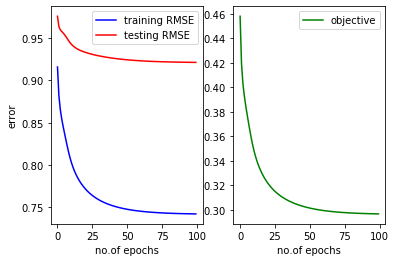

Epoch 1 RMSE TRAIN: 0.912343251147631 MAE TEST: 0.7828651455408705 RMSE TEST: 0.9795659121912593
Epoch 5 RMSE TRAIN: 0.8438459081450721 MAE TEST: 0.7612236589737925 RMSE TEST: 0.9533085070013801
Epoch 10 RMSE TRAIN: 0.8062791407197863 MAE TEST: 0.7505769840126794 RMSE TEST: 0.9403019675311984
Epoch 15 RMSE TRAIN: 0.7829394124754081 MAE TEST: 0.7433198782390813 RMSE TEST: 0.9315898073739202
Epoch 20 RMSE TRAIN: 0.7701985140845318 MAE TEST: 0.7395125497026634 RMSE TEST: 0.9273432198479649
Epoch 25 RMSE TRAIN: 0.7623305654677062 MAE TEST: 0.7370208632879744 RMSE TEST: 0.9246999975414542
Epoch 30 RMSE TRAIN: 0.7571060409629805 MAE TEST: 0.7352784292363863 RMSE TEST: 0.9228264476318284
Epoch 35 RMSE TRAIN: 0.7534597846130502 MAE TEST: 0.7339998556096742 RMSE TEST: 0.9214173286875111
Epoch 40 RMSE TRAIN: 0.7508243704953732 MAE TEST: 0.7330160559940194 RMSE TEST: 0.9203328517136572
Epoch 45 RMSE TRAIN: 0.7488719034263266 MAE TEST: 0.732248908844483 RMSE TEST: 0.9194857464752043
Epoch 50 RMSE 

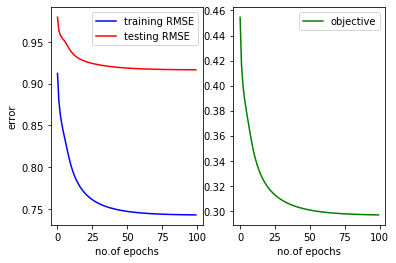

time taken: 4010.7798533439636 secs
MEAN RMSE TRAINING: 0.7422115544578269 MEAN RMSE TESTING: 0.9196876824078716


In [17]:
mf=HMF(user_explicit=user_explicit,item_explicit=movie_explicit)
mf.cross_validation(inter_data=df[['userid','movieid','rating']].to_numpy(),method='sgd')

## Recommending items to users

In [18]:
mf.recommend_items(10,656)  # recommending top 10 items to userid 656

Top 10 picks are:
item id: 1367 Name: Faust (1994)
item id: 589 Name: Wild Bunch, The (1969)
item id: 169 Name: Wrong Trousers, The (1993)
item id: 114 Name: Wallace & Gromit: The Best of Aardman Animation (1996)
item id: 1536 Name: Aiqing wansui (1994)
item id: 408 Name: Close Shave, A (1995)
item id: 718 Name: In the Bleak Midwinter (1995)
item id: 1500 Name: Santa with Muscles (1996)
item id: 646 Name: Once Upon a Time in the West (1969)
item id: 179 Name: Clockwork Orange, A (1971)


## Recommending Users to Items

In [19]:
mf.recommend_users(10,12) # Picking top 10 users who would prefer itemid 12

Top 10 users to recommend this item: 
user id 4
user id 118
user id 173
user id 270
user id 324
user id 355
user id 367
user id 414
user id 628
user id 688


## Interpretation of the Data

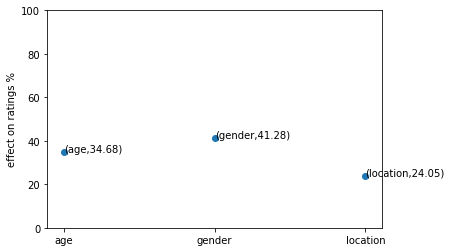

In [20]:
user_free=mf.final_user_free[:,:mf.item_explicit.shape[1]]
item_free=mf.final_item_free[:,:mf.user_explicit.shape[1]]
np.place(user_free,user_free<0,0)
np.place(item_free,item_free<0,0)
age_weight=item_free[:,0]
gender_weight=np.sum(item_free[:,1:3],axis=1)/2
location_weight=np.sum(item_free[:,3:],axis=1)/zipcode.shape[1]
sum=age_weight+gender_weight+location_weight
age_weight/=sum
gender_weight/=sum
location_weight/=sum
mean_percent_users=[np.mean(age_weight*100),np.mean(gender_weight*100),np.mean(location_weight*100)]
plt.figure()
plt.ylim([0,100])
plt.ylabel('effect on ratings %')
attributes=['age','gender','location']
plt.scatter(attributes,mean_percent_users)
for x,y in zip(attributes,[round(x,2) for x in mean_percent_users]):
    plt.text(x,y,'({},{})'.format(x,y))
plt.show()


Clearly as from above, gender of the user seems to have more effect on the ratings

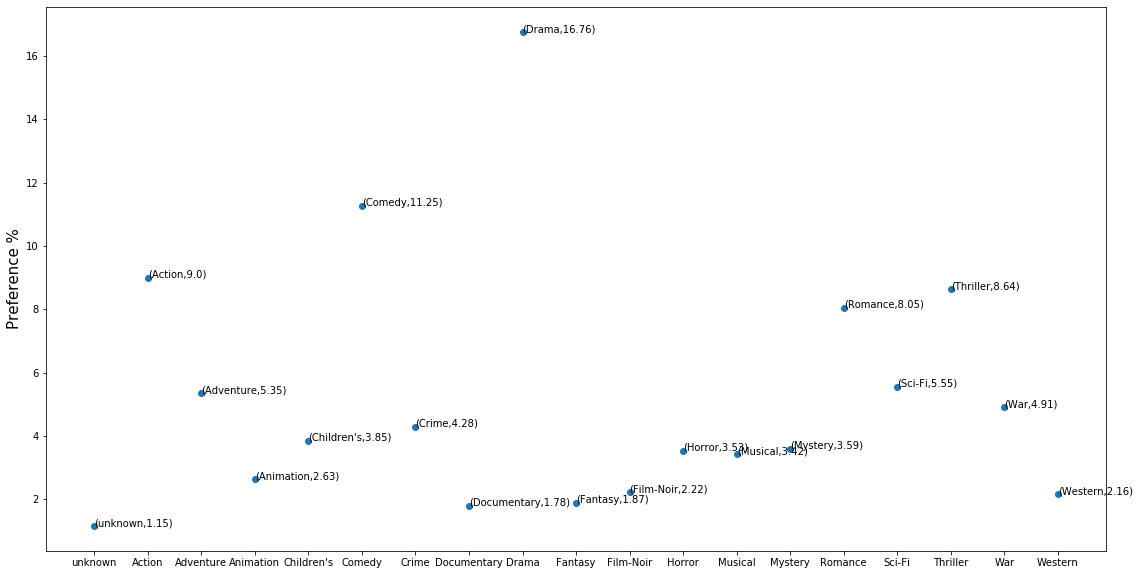

In [21]:
mean_percent_items=np.sum(user_free/np.sum(user_free,axis=1).reshape(-1,1),axis=0)*100/mf.user_count
genres=pd.read_csv('u.genre',delimiter='|',header=None)
plt.figure(figsize=(19,10))
plt.ylabel('Preference %',fontsize=15)
plt.scatter(genres.iloc[:,0],mean_percent_items)
for x,y in zip(genres.iloc[:,0],[round(x,2) for x in mean_percent_items]):
    plt.text(x,y,'({},{})'.format(x,y))
plt.show()


Drama seems to be the most preferred genre

In [22]:
final_df=pd.DataFrame(mf.final_prediciton)
final_df.to_csv('predictions.csv')

# Comparison with Basic MF using Surprise

In [23]:
#USING NMF
data = Dataset.load_builtin('ml-100k')
algo = NMF()
cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Evaluating RMSE, MAE of algorithm NMF on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9540  0.9699  0.9653  0.9699  0.9603  0.9639  0.0061  
MAE (testset)     0.7511  0.7610  0.7607  0.7632  0.7526  0.7577  0.0049  
Fit time          3.97    3.92    3.84    3.83    3.79    3.87    0.06    
Test time         0.15    0.08    0.14    0.08    0.14    0.12    0.03    


{'test_rmse': array([0.9539811 , 0.96988596, 0.96531622, 0.96991716, 0.96032196]),
 'test_mae': array([0.75109694, 0.76102389, 0.76068717, 0.7632145 , 0.75259154]),
 'fit_time': (3.968993902206421,
  3.919529914855957,
  3.8449039459228516,
  3.8314642906188965,
  3.7918033599853516),
 'test_time': (0.15445661544799805,
  0.08118104934692383,
  0.1444993019104004,
  0.08007431030273438,
  0.1444261074066162)}

In [24]:
#USING SVD
Data = Dataset.load_builtin('ml-100k')
algo = SVD()
cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9348  0.9444  0.9392  0.9283  0.9318  0.9357  0.0056  
MAE (testset)     0.7372  0.7433  0.7414  0.7321  0.7349  0.7378  0.0041  
Fit time          3.46    3.48    3.49    3.48    3.49    3.48    0.01    
Test time         0.10    0.16    0.10    0.16    0.10    0.13    0.03    


{'test_rmse': array([0.93482943, 0.94437221, 0.93924343, 0.92826276, 0.93179449]),
 'test_mae': array([0.73723643, 0.74327902, 0.74140996, 0.73207024, 0.7349144 ]),
 'fit_time': (3.456993341445923,
  3.4831125736236572,
  3.492344617843628,
  3.47839093208313,
  3.4935922622680664),
 'test_time': (0.10031247138977051,
  0.16414904594421387,
  0.09883642196655273,
  0.16452360153198242,
  0.09770512580871582)}

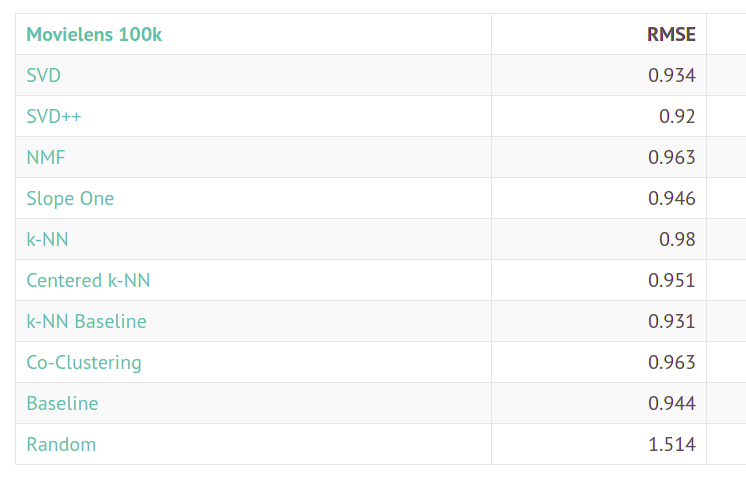

Clearly HMF outperforms all other MF approaches which primarily use only latent features.

# Extras
## Update rule and algo for ALS
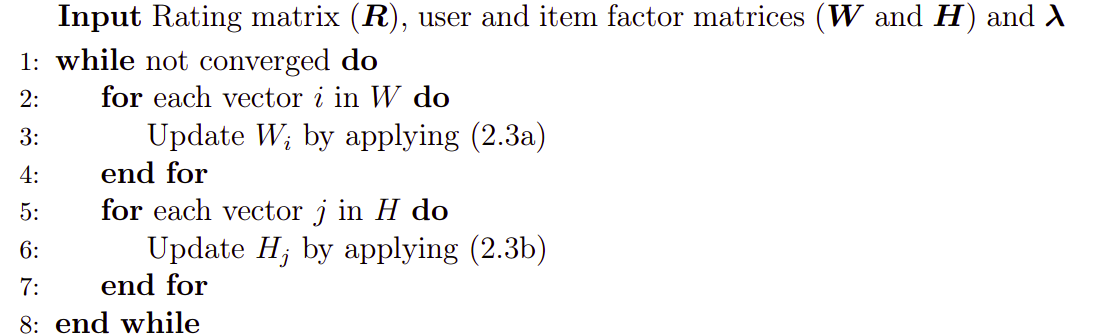
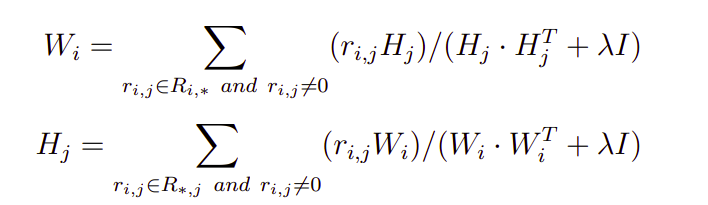
## Update rule and algo for CD
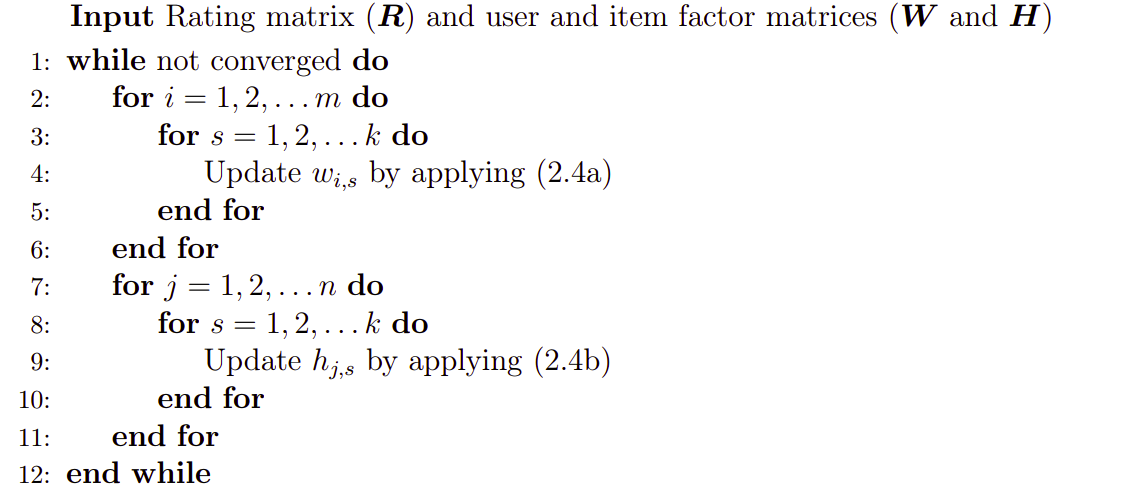
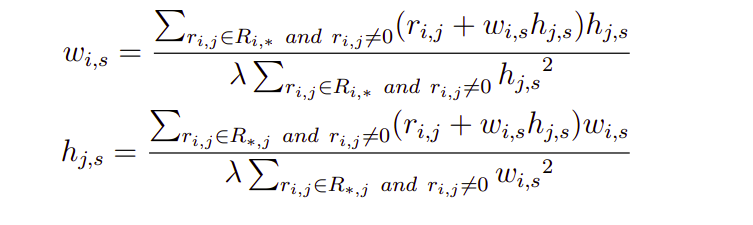
<br>
There are many more efficient and accurate algorithms for matrix factorisations such as DSGD,FPSGD,GASGD,NOMAD etc.Since this is just an introduction to MF,it is not included.More details on these can be found in [this article](http://repository.bilkent.edu.tr/bitstream/handle/11693/50632/%C3%96FA_MastersThesis.pdf?sequence=1&isAllowed=y#:~:text=The%20most%20important%20goal%20in,solutions%20to%20minimize%20the%20loss.)